In [ ]:

import pickle
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import joblib



In [ ]:
demand = pd.read_csv("demand_hourly.csv")
tss = TimeSeriesSplit(n_splits=5, test_size=24*60, gap=24)
df = demand.sort_values(by=['start_time_year', 'start_time_month',
                            'start_time_day', 'start_time_hour'])
df = df.drop(columns=['Unnamed: 0', 'duration_sec']).reset_index(drop=True)

standard_stations = pd.read_csv("stations_with_clusters.csv")

df = df.merge(standard_stations[['station_name', 'clusters']].rename(columns={
    "station_name":'start_station_name'}), on=["start_station_name"])

df = df[df.groupby('start_station_name')['start_station_name'].transform('size') >= 1000]

latest_trips = df.groupby('start_station_name').nth(-1)
earliest_trips = df.groupby('start_station_name').nth(0)


recently_operational_stations = latest_trips[(latest_trips['start_time_year'] == 2022) &
                                             (latest_trips['start_time_month'] >= 8)].index

stations_operational_since_2021 = earliest_trips[(earliest_trips['start_time_year'] == 2021)].index
df = df[df['start_station_name'].isin(stations_operational_since_2021)].reset_index(drop=True)



In [ ]:
del demand

In [ ]:
df.tail()

,start_station_name,start_time_year,start_time_month,start_time_day,start_time_hour,demand,start_time_week,start_time_quarter,start_time_dayofweek,is_holiday,clusters
1905841,Lyon St at Fell St,2022,11,30,15,1,48,4,2,True,1
1905842,Lyon St at Fell St,2022,11,30,16,1,48,4,2,True,1
1905843,Lyon St at Fell St,2022,11,30,17,1,48,4,2,True,1
1905844,Lyon St at Fell St,2022,11,30,18,1,48,4,2,True,1
1905845,Lyon St at Fell St,2022,11,30,22,1,48,4,2,True,1


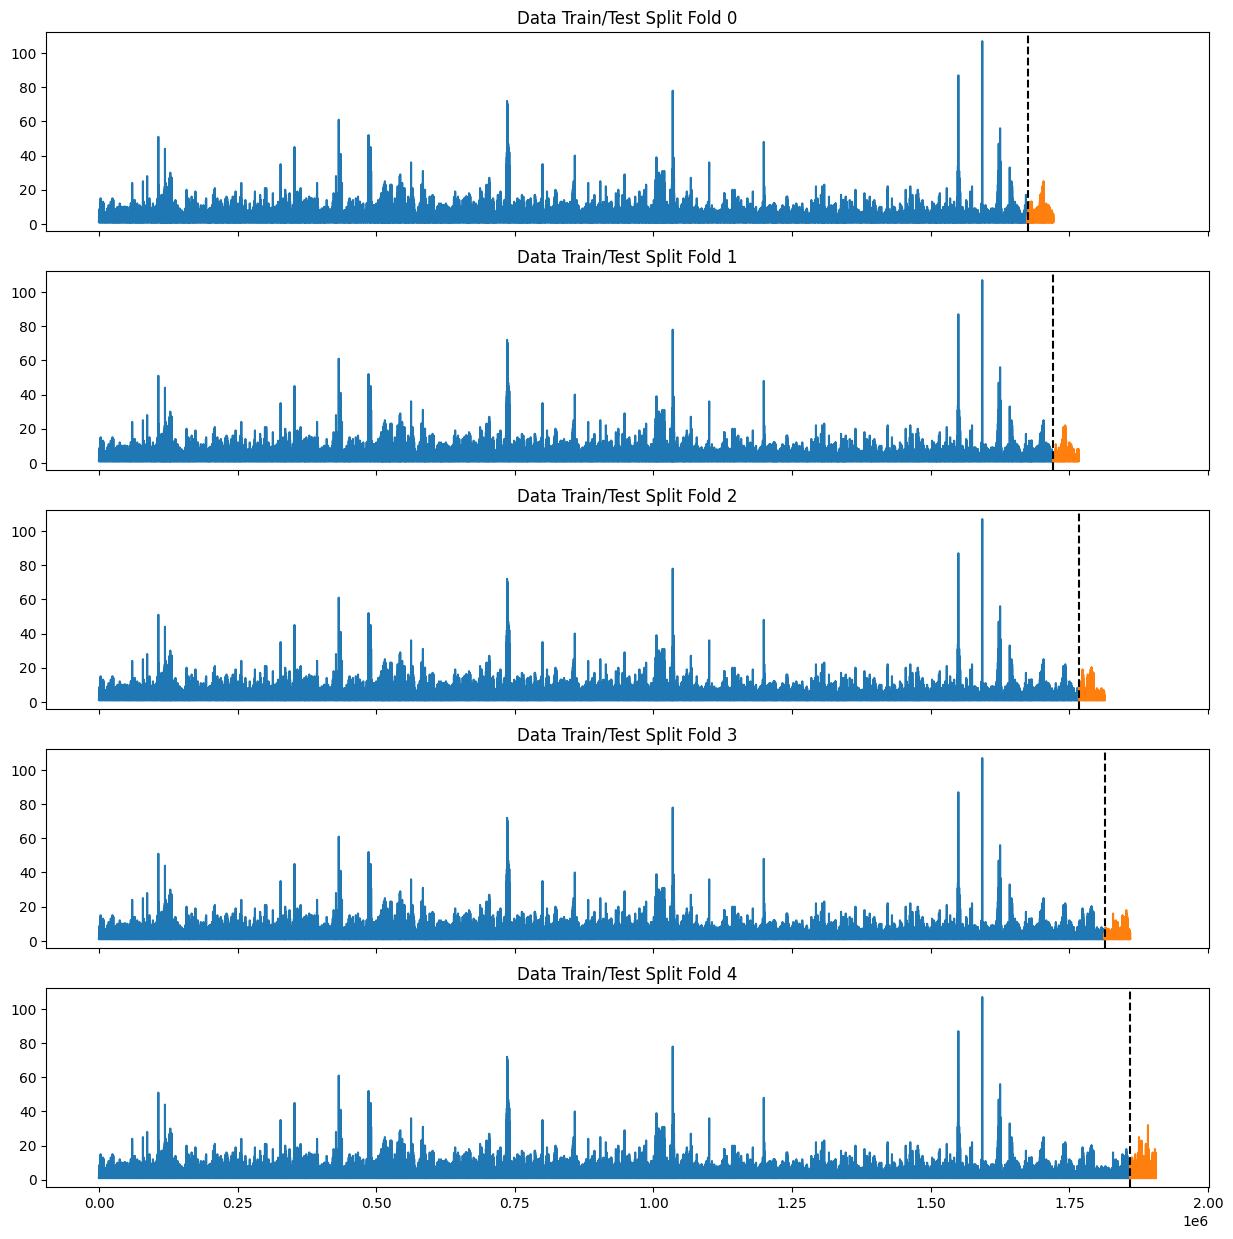

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*5*df['start_station_name'].nunique(), gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['demand'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['demand'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*5*df['start_station_name'].nunique(), gap=24)
df = df.sort_index()

fold = 0
preds = pd.DataFrame()
rmse = []
mape = []
le = preprocessing.LabelEncoder()
scaler = MinMaxScaler(feature_range=(1, 2))
SCALER_FEATURES = ["start_time_year", "start_time_month",
                   "start_time_day", "start_time_hour",
                   "start_time_week", "start_time_quarter",
                   "start_time_dayofweek"]
target_scaler = MinMaxScaler(feature_range=(1, 2))
df[SCALER_FEATURES] = scaler.fit_transform(df[SCALER_FEATURES])
df[['demand']] = target_scaler.fit_transform(df[['demand']])
df['start_station_name'] = le.fit_transform(df['start_station_name'])
df['is_holiday'] = df['is_holiday'].astype(int)


In [ ]:
24*10*df['start_station_name'].nunique()

92400

In [ ]:

for train_idx, val_idx in tss.split(df):

    train = df.iloc[train_idx]
    test = df.iloc[val_idx]


    FEATURES = ['start_station_name', 'start_time_year',
                'start_time_month', 'start_time_day',
                'start_time_hour',
                'start_time_week',
                'start_time_quarter',
                'start_time_dayofweek',
                'is_holiday']
    TARGET = 'demand'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = RandomForestRegressor(random_state=42)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    preds_out = X_test.copy()
    preds_out['actual_demand'] = y_test
    preds_out['pred'] = y_pred
    preds = preds.append(preds_out)
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_score = mean_absolute_percentage_error(y_test, y_pred)
    rmse.append(rmse_score)
    mape.append(mape_score)
    print(rmse_score)
    print(mape_score)
    print(preds.head())
    print(preds.tail())

print(f"Mean RMSE: {np.mean(rmse)}")
print(f"Mean MAPE: {np.mean(mape)}")
del df
del X_train
del y_train
del X_test

0.018185341191443757
0.010544275647918776
         start_station_name  start_time_year  start_time_month  \
1674846                 168              2.0          1.727273   
1674847                 171              2.0          1.727273   
1674848                 174              2.0          1.727273   
1674849                 176              2.0          1.727273   
1674850                 177              2.0          1.727273   

         start_time_day  start_time_hour  start_time_week  start_time_quarter  \
1674846        1.466667         1.347826         1.692308            1.666667   
1674847        1.466667         1.347826         1.692308            1.666667   
1674848        1.466667         1.347826         1.692308            1.666667   
1674849        1.466667         1.347826         1.692308            1.666667   
1674850        1.466667         1.347826         1.692308            1.666667   

         start_time_dayofweek  is_holiday  actual_demand      pred  
16748

0.01370600386785144
0.00943140993413682
         start_station_name  start_time_year  start_time_month  \
1674846                 168              2.0          1.727273   
1674847                 171              2.0          1.727273   
1674848                 174              2.0          1.727273   
1674849                 176              2.0          1.727273   
1674850                 177              2.0          1.727273   

         start_time_day  start_time_hour  start_time_week  start_time_quarter  \
1674846        1.466667         1.347826         1.692308            1.666667   
1674847        1.466667         1.347826         1.692308            1.666667   
1674848        1.466667         1.347826         1.692308            1.666667   
1674849        1.466667         1.347826         1.692308            1.666667   
1674850        1.466667         1.347826         1.692308            1.666667   

         start_time_dayofweek  is_holiday  actual_demand      pred  
1674846

In [ ]:
suf = "_nov_2022"

preds.to_csv(f"test_predictions{suf}.csv")
del preds

filename = f'demand_model{suf}.sav'
joblib.dump(reg, filename)
del reg

filename = f'target_scaler{suf}.sav'
joblib.dump(target_scaler, filename)
del target_scaler

filename = f'scaler{suf}.sav'
joblib.dump(scaler, filename)
del scaler

filename = f'label_encoder{suf}.sav'
joblib.dump(le, filename)
del reg


In [ ]:
y_test

In [ ]:
#preds['demand'] = preds['actual_demand']
#preds[SCALER_FEATURES] = scaler.inverse_transform(preds[SCALER_FEATURES])

In [ ]:
preds
